In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from scipy.stats import entropy

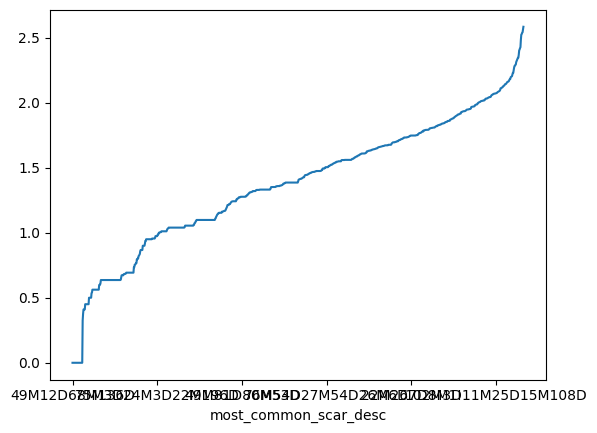

In [6]:
# Look across days, calculate entropy for each day

fulldata_per_day = {} 
entropy_per_dataset = {}
scar_obs_per_day = {}
singlets = {}

doublet_threshold = 0.5

for umap_path in glob.glob('../data/umap/*.csv'):
    day = umap_path.split('/')[-1].replace('.csv','')
    umap = pd.read_csv(umap_path,index_col=0)
    meta = pd.read_csv(umap_path.replace('umap','meta'),index_col=0)
    fulldata_per_day[day] = pd.read_csv('../data/scar_data_with_doublet_prob.csv', index_col=0).join(umap,how='inner').join(meta,how='inner')
    singlets[day] = fulldata_per_day[day][ fulldata_per_day[day]['scar_posterior_doublet']<doublet_threshold ]
    
    clustering_col = 'clusters_buys' if 'clusters_buys'  in singlets[day] else 'seurat_clusters'
    scar_obs = singlets[day]['most_common_scar_desc'].value_counts(sort=True)
    
    scar_obs_per_cluster = pd.DataFrame(
    {cluster:df['most_common_scar_desc'].value_counts(sort=True)
    for cluster, df in singlets[day].groupby(clustering_col) 
    }).fillna(0)
        
    scars_sorted_by_entropy = scar_obs_per_cluster.apply(entropy,axis=1).sort_values(ascending=True)
    entropy_per_dataset[day] = scars_sorted_by_entropy
    scar_obs_per_day[day] = scar_obs_per_cluster.sum(1)
scar_obs_per_day = pd.DataFrame(scar_obs_per_day)

### Entropy calculation
min_obs = 5
select_scars = scar_obs_per_day[scar_obs_per_day.sum(1)>min_obs].index
ed = pd.DataFrame(entropy_per_dataset).loc[select_scars]
ed = ed[['day7m','day4','day5m','day0']]
sorted_by_entropy = ed.max(axis=1).sort_values()
sorted_by_entropy.plot()
sorted_by_entropy_dict = sorted_by_entropy.to_dict()

## Export
fulldata_per_day = pd.concat(fulldata_per_day).droplevel(0)
fulldata_per_day['scar_entropy'] = [ 
    sorted_by_entropy_dict.get(row['most_common_scar_desc'], None) for cell, row in fulldata_per_day.iterrows()
]

# Write final callset
fulldata_per_day = fulldata_per_day[~fulldata_per_day.index.duplicated(keep='first')]
fulldata_per_day.rename({'most_common_scar_desc':'scar'},axis=1).to_csv('../data/full_dataset_calls.csv')